In [1]:
!pip install google-play-scraper pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 408.0 kB/s eta 0:00:00


In [2]:
!pip install vaderSentiment pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
from google_play_scraper import Sort, reviews
app_id = 'com.zhiliaoapp.musically'
all_reviews = []
count = 12000
for _ in range(count // 200 + 1):
    reviews_batch, _ = reviews(
        app_id,
        lang='en',
        count=200,
        sort=Sort.NEWEST
    )
    all_reviews.extend(reviews_batch)
    if len(all_reviews) >= count:
        break
all_reviews = all_reviews[:count]
reviews_df = pd.DataFrame(all_reviews)
reviews_df = reviews_df[['userName', 'content', 'score', 'at']]
reviews_df.columns = ['username', 'review', 'score', 'time']
reviews_df.to_csv('tiktok_reviews.csv', index=False)
print("Data collection complete. Saved to tiktok_reviews.csv")

Data collection complete. Saved to tiktok_reviews.csv


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
reviews_df = pd.read_csv('tiktok_reviews.csv')
analyzer = SentimentIntensityAnalyzer()
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
reviews_df['compound_score'] = reviews_df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
reviews_df['sentiment'] = reviews_df['compound_score'].apply(classify_sentiment)
reviews_df.to_csv('tiktok_reviews_labeled.csv', index=False)
print("Sentiment analysis complete. Saved to tiktok_reviews_labeled.csv")

Sentiment analysis complete. Saved to tiktok_reviews_labeled.csv


In [5]:
reviews_df['sentiment'].value_counts()

,count
sentiment,
positive,7020
neutral,3780
negative,1200


In [6]:
#since the lowest class negative has 900 values we are taking 900 as the sample size
sample_size = 900

positive_df = reviews_df[reviews_df['sentiment'] == 'positive'].sample(sample_size, random_state=42)
neutral_df = reviews_df[reviews_df['sentiment'] == 'neutral'].sample(sample_size, random_state=42)
negative_df = reviews_df[reviews_df['sentiment'] == 'negative'].sample(sample_size, random_state=42)

balanced_df = pd.concat([positive_df, neutral_df, negative_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df.to_csv('balanced_reviews.csv', index=False)
print("Balanced dataset saved to 'balanced_reviews.csv'")

Balanced dataset saved to 'balanced_reviews.csv'


In [7]:
df = pd.read_csv('balanced_reviews.csv')
df['sentiment'].value_counts()

,count
sentiment,
neutral,900
positive,900
negative,900


In [8]:
df.head(10)

,username,review,score,time,compound_score,sentiment
0,Aasis,Gud,1,2024-08-22 14:46:54,0.0000,neutral
1,Sikandar Hayat,Live ap,4,2024-08-22 17:04:03,0.0000,neutral
2,REB ELLION,Dem papa dem dey finish my data,1,2024-08-22 15:16:56,0.0000,neutral
3,John Crowley,Brilliant highly recommended 👌 👍,5,2024-08-22 16:31:16,0.9112,positive
4,Mst.Monalisa Islam40,Valo,5,2024-08-22 14:46:37,0.0000,neutral
5,Inayat ullah,Til too is so nice app,5,2024-08-22 16:45:59,0.5598,positive
6,Rubel Babu,nice apy,5,2024-08-22 17:00:00,0.4215,positive
7,Danielle Shanley,It is goid,5,2024-08-22 16:34:58,0.0000,neutral
8,Ben Campbell,Randomly stopped being able to follow anyone,1,2024-08-22 16:10:44,-0.2263,negative
9,Mainul Hasan Shanto,nice,5,2024-08-22 17:11:38,0.4215,positive


In [9]:
import string,re,nltk,spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # face related emojis
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'https:\w+', '', text)
  text = text.lower().strip()
  doc = nlp(text)
  tokens = [token.text for token in doc if not token.is_stop and not token.text.isspace() and not token.is_punct]
  s=' '.join(tokens)
  doc=nlp(s)
  final_tokens=[]
  for i in doc:
    final_tokens.append(i.lemma_)
  return ' '.join(final_tokens)

In [10]:
df['cleaned_reviews']=df['review'].apply(preprocess_text)
df.head(10)

,username,review,score,time,compound_score,sentiment,cleaned_reviews
0,Aasis,Gud,1,2024-08-22 14:46:54,0.0000,neutral,gud
1,Sikandar Hayat,Live ap,4,2024-08-22 17:04:03,0.0000,neutral,live ap
2,REB ELLION,Dem papa dem dey finish my data,1,2024-08-22 15:16:56,0.0000,neutral,dem papa dem dey finish datum
3,John Crowley,Brilliant highly recommended 👌 👍,5,2024-08-22 16:31:16,0.9112,positive,brilliant highly recommend
4,Mst.Monalisa Islam40,Valo,5,2024-08-22 14:46:37,0.0000,neutral,valo
5,Inayat ullah,Til too is so nice app,5,2024-08-22 16:45:59,0.5598,positive,til nice app
6,Rubel Babu,nice apy,5,2024-08-22 17:00:00,0.4215,positive,nice apy
7,Danielle Shanley,It is goid,5,2024-08-22 16:34:58,0.0000,neutral,goid
8,Ben Campbell,Randomly stopped being able to follow anyone,1,2024-08-22 16:10:44,-0.2263,negative,randomly stop able follow
9,Mainul Hasan Shanto,nice,5,2024-08-22 17:11:38,0.4215,positive,nice


In [11]:
df['target']=df['sentiment'].map({'positive':1,"negative":-1,'neutral':0})
df.head(10)

,username,review,score,time,compound_score,sentiment,cleaned_reviews,target
0,Aasis,Gud,1,2024-08-22 14:46:54,0.0000,neutral,gud,0
1,Sikandar Hayat,Live ap,4,2024-08-22 17:04:03,0.0000,neutral,live ap,0
2,REB ELLION,Dem papa dem dey finish my data,1,2024-08-22 15:16:56,0.0000,neutral,dem papa dem dey finish datum,0
3,John Crowley,Brilliant highly recommended 👌 👍,5,2024-08-22 16:31:16,0.9112,positive,brilliant highly recommend,1
4,Mst.Monalisa Islam40,Valo,5,2024-08-22 14:46:37,0.0000,neutral,valo,0
5,Inayat ullah,Til too is so nice app,5,2024-08-22 16:45:59,0.5598,positive,til nice app,1
6,Rubel Babu,nice apy,5,2024-08-22 17:00:00,0.4215,positive,nice apy,1
7,Danielle Shanley,It is goid,5,2024-08-22 16:34:58,0.0000,neutral,goid,0
8,Ben Campbell,Randomly stopped being able to follow anyone,1,2024-08-22 16:10:44,-0.2263,negative,randomly stop able follow,-1
9,Mainul Hasan Shanto,nice,5,2024-08-22 17:11:38,0.4215,positive,nice,1


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [13]:
X=df['cleaned_reviews']
y=df['target']
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
pipe = Pipeline([
    ('vectorizer',TfidfVectorizer()),
    ('model',SVC())
])

In [15]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('model', SVC())])

In [16]:
y_pred=pipe.predict(X_test)

In [17]:
print(accuracy_score(y_pred,y_test))

0.9425925925925925


In [18]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          -1       1.00      0.95      0.98       193
           0       0.93      0.93      0.93       160
           1       0.90      0.95      0.92       187

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540



Text(50.722222222222214, 0.5, 'Actual')

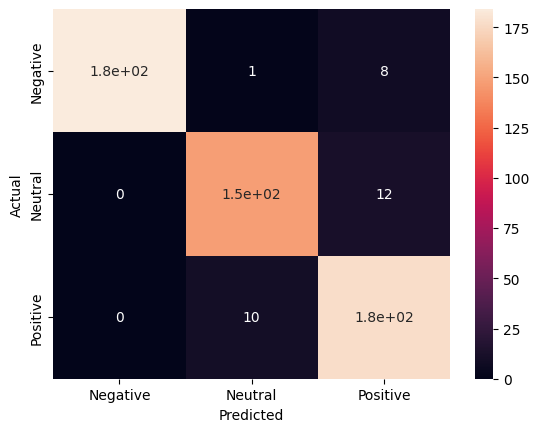

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm,annot=True,xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
y_pred_bin = label_binarize(y_pred, classes=[-1, 0, 1])
auroc = roc_auc_score(y_test_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUROC: {auroc:.2f}")

AUROC: 0.96


In [24]:
auroc = roc_auc_score(y_test_bin, y_pred_bin, average="micro", multi_class="ovr")
print(f"AUROC: {auroc:.2f}")

AUROC: 0.96


In [31]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          -1       1.00      0.95      0.98       193
           0       0.93      0.93      0.93       160
           1       0.90      0.95      0.92       187

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540

